# 데이터 처리 환경 설정

In [1]:
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import collections
import datetime as dt
import time
from sklearn.linear_model import LinearRegression


from matplotlib import font_manager, rc
from matplotlib import style
style.use('ggplot')
%matplotlib inline

font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

pd.set_option('display.max_rows', 220)
pd.set_option('display.max_columns', 20)

## 변수 설명
* gu_list: 구 이름 리스트
* gu_count : 구별 동 갯수 리스트
* dong_list : 읍면동 이름 리스트

## Linear Regression function
* def predict_people(city, want):
    * city:동읍면, want:총 유동인구
    * ex) predict_people('장전1동', '총 유동인구')

# Q&A
* 유동인구를 예측했을 때 음수값이 나올 때는 어떻게 해야하는가?
    * 남구 대연3동, 해운대구 우2동
    * 코로나 때문인지 확인하고 그렇다면 그 값을 없애보자-이사님

In [2]:
def predict_people(city, want):
    data['년월값']=0
    data['년월값']=pd.to_datetime(data['년월'])
    data['년월값']=data['년월값'].map(dt.datetime.toordinal)
    
    X=pd.DataFrame(data[data['읍면동']==city]['년월값'])
    y=pd.DataFrame(data[data['읍면동']==city][want])

    X['년월']=X['년월값'].map(dt.date.fromordinal)
    X['년월']=pd.to_datetime(X['년월'])

    data_list=X['년월'].to_list()
    data_list
    df=pd.DataFrame({'year_month': data_list})

    X=X.reset_index()
    X['년월']= df['year_month'].dt.strftime('%Y-%m')
    
    line_fitter=LinearRegression()
    line_fitter.fit(X['년월값'].values.reshape(-1,1),y)

    predict=line_fitter.predict([[X['년월값'][11]+30]])
    print(str(int(np.round([[predict]][-1][-1])))+'명')
    
    plt.plot(X['년월'], y, 'o')
    plt.plot(X['년월'],line_fitter.predict(X['년월값'].values.reshape(-1,1)))
    plt.xticks(rotation=20)
    plt.show()
# line_fitter.coef_, line_fitter.intercept_

In [3]:
def predict_money_power(gu):
    data_money['년월값']=0
    data_money['년월값']=pd.to_datetime(data_money['년도월'])
    data_money['년월값']=data_money['년월값'].map(dt.datetime.toordinal)

    X=pd.DataFrame(data_money[data_money['구군']==gu]['년월값'])
    y=pd.DataFrame(data_money[data_money['구군']==gu]['카드이용금액(천원)'])

    X['년월']=X['년월값'].map(dt.date.fromordinal)
    X['년월']=pd.to_datetime(X['년월'])

    data_list=X['년월'].to_list()
    data_list
    df=pd.DataFrame({'year_month': data_list})    

    X=X.reset_index()
    X['년월']= df['year_month'].dt.strftime('%Y-%m')

    line_fitter=LinearRegression()
    line_fitter.fit(X['년월값'].values.reshape(-1,1),y)

    a=line_fitter.predict([[X['년월값'][2]+91]])

    print(str(int(np.round([[a]][-1][-1])))+'원')

    plt.plot(X['년월'], y, 'o')
    plt.plot(X['년월'],line_fitter.predict(X['년월값'].values.reshape(-1,1)))
    plt.xticks(rotation=20)
    plt.show()

In [1]:
def z_score_normalize(lst):
    normalized = []
    for value in lst:
        normalized_num = (value - np.mean(lst)) / np.std(lst)
        normalized.append(normalized_num)
    return normalized

In [2]:
def analysis_store(dong):
    Depts = ["경쟁업체(십)","영업이익/매출액(%)","구매력(백만)","유동인구(만)", "총인구(천)"]
    # 진입 상권
    want_store=dong

    want_data=data_per_dong[data_per_dong['읍면동']==want_store]
    want_s=[want_data['경쟁업체 수'].tolist()[0]/10, want_data['영업이익/매출액(%)'].tolist()[0], want_data['예측 구매력'].tolist()[0]/1000000, 
            want_data['예측 유동인구'].tolist()[0]/10000, want_data['총 인구'].tolist()[0]/1000, want_data['경쟁업체 수'].tolist()[0]/10]

    # 평균 상권
    ave_data=data_per_dong[data_per_dong['구군']==want_data['구군'].tolist()[0]]
    ave_s=[ave_data['경쟁업체 수'].sum()/len(ave_data['경쟁업체 수'])/10, ave_data['영업이익/매출액(%)'].sum()/len(ave_data['영업이익/매출액(%)']), 
           want_data['구의 동별 평균 구매력'].tolist()[0]/1000000, ave_data['예측 유동인구'].sum()/len(ave_data['예측 유동인구'])/10000, 
           want_data['구의 동별 평균 인구'].tolist()[0]/1000,ave_data['경쟁업체 수'].sum()/len(ave_data['경쟁업체 수'])/10]

    nor_want_s=z_score_normalize(want_s)
    nor_ave_s=z_score_normalize(ave_s)

    grade_store_list=[]
    for i in range(len(nor_want_s)):
        if i==0:
            grade_store_list.append(-(nor_want_s[i]-nor_ave_s[i])*4)
        else:
            grade_store_list.append(nor_want_s[i]-nor_ave_s[i])

    grade_store=sum(grade_store_list)

    grade=''
    if grade_store>=0.52:
        grade='좋음'
    elif -0.08<=grade_store<0.52:
        grade='양호'
    elif -0.42<=grade_store<-0.08:
        grade='고려'
    elif grade_store<-0.42:
        grade='나쁨'


    plt.figure(figsize=(10,6))
    plt.subplot(polar=True)

    theta = np.linspace(0, 2 * np.pi, len(want_s))

    (lines,labels) = plt.thetagrids(range(0,360, int(360/len(Depts))), (Depts))

    plt.plot(theta, want_s)
    plt.fill(theta, want_s, 'b', alpha=0.1)
    plt.plot(theta, ave_s)
    plt.legend(labels=(want_store,want_data['구군'].tolist()[0]+' 평균 상권'),loc=1)
    plt.title("상권분석 서비스 결과->"+grade)

    plt.show();

## 데이터 불러오기

In [3]:
data19=pd.read_csv("./data/2019동별 유동인구.csv", encoding='utf-8')
data20=pd.read_csv("./data/2020동별 유동인구.csv", encoding='cp949')
data_total=pd.read_csv('./data/2019년도 부산시 총인구(동별).csv', encoding='cp949')
data_money=pd.read_csv("./data/부산_구군별 총 카드이용금액.csv", encoding='utf-8')
data_rival=pd.read_csv("./data/부산_읍면동별_경쟁업체수.csv", encoding='cp949')
data_benifit=pd.read_csv('./data/부산_읍면동별_매출대비이익.csv',encoding='cp949')

NameError: name 'pd' is not defined

## 읍면동 list로 뽑기

In [6]:
data_dong_list=[]
for i in data20['읍면동'].unique():
    data_dong_list.append(i)

## 2019년 데이터 전처리

In [7]:
for i in range(6,13):
    globals()['df{}'.format(i)]=data19[data19['월']==i]
    
data19=pd.concat([df8,df9,df10,df11,df12], axis=0)
data19=data19.reset_index()

data19['평균 유동인구']=[pd.to_numeric(data19['평균 유동인구'][i].replace(',','').replace('명','')) for i in range(len(data19['평균 유동인구']))]

data_move=[]
for i in range(8,13):
    for j in data_dong_list:
        data_move.append(data19[(data19['읍면동']==j)&(data19['월']==i)]['평균 유동인구'].sum())
        
data19=data19[data19['요일']=='일']
data19=data19.reset_index()
data19['총 유동인구']=0
for i in range(len(data_move)):
    data19['총 유동인구'][i]=data_move[i]
    
data19=data19[(data19['요일']=='일')]
data19=data19[['구군','년','월','읍면동','총 유동인구']]

## 2020년 data 전처리

In [9]:
data20['주중/주말 유동인구']=[pd.to_numeric(data20['주중/주말 유동인구'][i].replace(',','')) for i in range(len(data20['주중/주말 유동인구']))]
data_move=[]
for i in range(1,8):
    for j in data_dong_list:
        data_move.append(data20[(data20['읍면동']==j)&(data20['월']==i)]['주중/주말 유동인구'].sum())
        
data20['총 유동인구']=0
for i in range(len(data_move)):
    data20['총 유동인구'][i]=data_move[i]
    
data20=data20[data20['요일']=='일']
data20=data20[['구군','년','월','읍면동','총 유동인구']]

## 19-20 데이터 합치기

In [10]:
data=pd.concat([data19, data20], axis=0)
data=data.reset_index()
for i in range(len(data['읍면동'])):
    if ('제' in data['읍면동'][i]):
        if ('거제' not in data['읍면동'][i]):
            data['읍면동'][i]=data['읍면동'][i].replace('제','')

## 총 인구수 데이터 전처리

In [11]:
data_total=data_total.drop(0)
data_total=data_total.reset_index()
data_total=data_total[['행정구역(동읍면)별','2019']]
data_total.columns=['읍면동','총 인구수']
for i in range(len(data_total['읍면동'])):
    if ('제' in data_total['읍면동'][i]):
        if ('거제' not in data_total['읍면동'][i]):
            data_total['읍면동'][i]=data_total['읍면동'][i].replace('제','')
        elif ('거제제' in data_total['읍면동'][i]):
            data_total['읍면동'][i]=data_total['읍면동'][i].replace('거제제','거제')
        
a=[]
for i in range(len(data_total['읍면동'])):
    if '구' in data_total['읍면동'][i][-1]:
        a.append(i)
        
data_total=data_total.drop([1, 11, 25, 38, 50, 71, 85, 103, 117, 136, 153, 171, 180, 193, 204])
data_total=data_total.reset_index()

In [12]:
data['년월']=0
for i in range(len(data['년'])):
        data['년월'][i]=str(data['년'][i])+'.'+str(data['월'][i])
        data['년월'][i]=pd.to_datetime(data['년월'][i])
        

data_list=data['년월'].to_list()
data_list
df=pd.DataFrame({'year_month': data_list})

data['년월']= df['year_month'].dt.strftime('%Y-%m')    

# 2020년 08월 유동인구 예측
* 함수명이랑 같은 변수 사용하면 'list' object is not callable 이 에러 뜸

In [13]:
predict_list=data['읍면동'].unique().tolist()
predict_people_all=[]
for i in predict_list:
    data['년월값']=0
    data['년월값']=pd.to_datetime(data['년월'])
    data['년월값']=data['년월값'].map(dt.datetime.toordinal)

    X=pd.DataFrame(data[data['읍면동']==i]['년월값'])
    y=pd.DataFrame(data[data['읍면동']==i]['총 유동인구'])
    
    X['년월']=X['년월값'].map(dt.date.fromordinal)
    X['년월']=pd.to_datetime(X['년월'])
    
    data_list=X['년월'].to_list()
    data_list
    df=pd.DataFrame({'year_month': data_list})    
    
    X=X.reset_index()
    X['년월']= df['year_month'].dt.strftime('%Y-%m')
    
    line_fitter=LinearRegression()
    line_fitter.fit(X['년월값'].values.reshape(-1,1),y)
    
    a=line_fitter.predict([[X['년월값'][11]+30]])
    predict_people_all.append(int(np.round([[a]][-1][-1])))

## 동별, 달별 데이터 구축
* 월별 유동인구 수 데이터
* 2020-08 유동인구 예측 데이터


In [14]:
data_per_month=data[['구군','읍면동','년월','총 유동인구']]

In [15]:
data_per_dong=data[data['월']==8]
data_per_dong['총 인구']=0
for i in range(len(data_per_dong['읍면동'])):
    for j in range(len(data_total['읍면동'])):
        if (data_per_dong['읍면동'][i]==data_total['읍면동'][j]):
                data_per_dong['총 인구'][i]=data_total['총 인구수'][j]
                
# data['총 인구']=data['읍면동'].apply(lambda x: data_total.loc[data_total['읍면동']==x].iloc[0,2])
                
data_per_dong=data_per_dong[['구군','읍면동','년월','총 유동인구','총 인구']]

In [16]:
data_per_dong=data_per_dong[['구군','읍면동','총 인구']]
data_per_dong['예측 유동인구']=0
for i in range(len(predict_people_all)):
    data_per_dong['예측 유동인구'][i]=predict_people_all[i]

# 2020년 8월 구매력 예측

## 부산시_구별_구매력 데이터 전처리

In [17]:
data_money['년도월']=0
for i in range(len(data_money['년도'])):
        data_money['년도월'][i]=str(data_money['년도'][i])+'.'+str(data_money['월'][i])
        data_money['년도월'][i]=pd.to_datetime(data_money['년도월'][i])
        

data_money_list=data_money['년도월'].to_list()
data_money_list
df=pd.DataFrame({'year_month': data_money_list})

data_money['년도월']= df['year_month'].dt.strftime('%Y-%m') 

for i in range(len(data_money['3개월 총 카드이용금액(천원)'])):
    data_money['3개월 총 카드이용금액(천원)'][i]=int(data_money['3개월 총 카드이용금액(천원)'][i].replace(',',''))
    
data_money=data_money[['구군','년도월','3개월 총 카드이용금액(천원)']]
data_money.columns=['구군','년도월','카드이용금액(천원)']

## Linear Regression을 이용한 부산시_구별_구매력 예측

In [18]:
data_money_list=data_money['구군'].tolist()

money_power=[]
for i in data_money_list:
    data_money['년월값']=0
    data_money['년월값']=pd.to_datetime(data_money['년도월'])
    data_money['년월값']=data_money['년월값'].map(dt.datetime.toordinal)

    X=pd.DataFrame(data_money[data_money['구군']==i]['년월값'])
    y=pd.DataFrame(data_money[data_money['구군']==i]['카드이용금액(천원)'])

    X['년월']=X['년월값'].map(dt.date.fromordinal)
    X['년월']=pd.to_datetime(X['년월'])

    data_list=X['년월'].to_list()
    data_list
    df=pd.DataFrame({'year_month': data_list})    

    X=X.reset_index()
    X['년월']= df['year_month'].dt.strftime('%Y-%m')

    line_fitter=LinearRegression()
    line_fitter.fit(X['년월값'].values.reshape(-1,1),y)

    a=line_fitter.predict([[X['년월값'][2]+91]])
    money_power.append(int(np.round([[a]][-1][-1])))
    
data_money['예측 구매력']=0
for i in range(len(money_power)):
    data_money['예측 구매력'][i]=money_power[i]
    
data_predict_money=data_money.drop_duplicates('예측 구매력')
data_predict_money=data_predict_money[['구군','예측 구매력']]

data_per_dong_sum=data_per_dong.groupby('구군').sum()
data_per_dong_sum=data_per_dong_sum.reset_index()

data_predict_money['총 인구']=0
data_predict_money['예측 유동인구']=0

for i in range(len(data_predict_money['구군'])):
    for j in range(len(data_per_dong_sum['구군'])):
        if (data_predict_money['구군'][i]==data_per_dong_sum['구군'][j]):
            data_predict_money['총 인구'][i]=data_per_dong_sum['총 인구'][j]
            data_predict_money['예측 유동인구'][i]=data_per_dong_sum['예측 유동인구'][j]

## 구별 데이터를 동별 데이터로 변환작업

In [19]:
data_predict_money['인구 별 구매력']=0
data_predict_money['인구 별 구매력']=data_predict_money['예측 구매력']/data_predict_money['총 인구']

data_money_power=pd.merge(data_predict_money, data_per_dong,on='구군',how='right')
data_money_power=data_money_power[['구군','읍면동','총 인구_y','인구 별 구매력','총 인구_x','예측 구매력']]

data_money_power['구의 동별 평균 인구']=0
data_money_power['구의 동별 평균 구매력']=0

gu_count=[]
people_per_dong_in_gu=[]
money_per_dong_in_gu=[]
gu_list=data_money_power['구군'].unique().tolist()
dong_list=data_money_power['읍면동'].unique().tolist()
for i in gu_list:
    gu_count.append(collections.Counter(data_money_power['구군'])[i])

for i in range(len(gu_count)):
    people_per_dong_in_gu.append(data_money_power['총 인구_x'].unique().tolist()[i]/gu_count[i])
    money_per_dong_in_gu.append(round(data_money_power['예측 구매력'].unique().tolist()[i]/gu_count[i],-3))
    
array_people = []
array_money=[]
for i in people_per_dong_in_gu:
    for j in gu_count:
        array_people.append(i)
        
for i in money_per_dong_in_gu:
    for j in gu_count:
        array_money.append(i)        
            
for i in range(len(array_money)):
    data_money_power['구의 동별 평균 인구'][i]=array_people[i]
    data_money_power['구의 동별 평균 구매력'][i]=array_money[i]
    
data_money_power['동별 구매력']=0
data_money_power['동별 구매력']=data_money_power['총 인구_y']*data_money_power['인구 별 구매력']

data_money_power['동별 구매력']=round(data_money_power['동별 구매력'],-3)

## 동별 데이터에 병합

In [20]:
data_per_dong=pd.merge(data_per_dong,data_money_power,on='읍면동',how='left')
data_per_dong=data_per_dong[['구군_x','읍면동','총 인구','예측 유동인구','동별 구매력',
                             '구의 동별 평균 인구','구의 동별 평균 구매력']]
data_per_dong.columns=['구군','읍면동','총 인구','예측 유동인구','예측 구매력',
                      '구의 동별 평균 인구','구의 동별 평균 구매력']

# 동별 경쟁업체 수 병합

In [21]:
data_rival=data_rival[['행정동명','편의점수','대형마트수','슈퍼마켓수','합계']]
data_rival.columns=['읍면동','편의점 수','대형마트 수','슈퍼마켓 수','경쟁업체 수']
data_per_dong=pd.merge(data_per_dong, data_rival, on='읍면동', how='left')

In [22]:
for i in range(len(data_per_dong['예측 구매력'])):
    data_per_dong['예측 구매력'][i]=int(data_per_dong['예측 구매력'][i])
    data_per_dong['편의점 수'][i]=int(data_per_dong['편의점 수'][i])
    data_per_dong['대형마트 수'][i]=int(data_per_dong['대형마트 수'][i])
    data_per_dong['슈퍼마켓 수'][i]=int(data_per_dong['슈퍼마켓 수'][i])
    data_per_dong['경쟁업체 수'][i]=int(data_per_dong['경쟁업체 수'][i])

# 모든 데이터 병합

* merge 하면 열로 부르기 안 됨

In [23]:
data_all=pd.merge(data_per_month, data_per_dong)

data_all

,구군,읍면동,년월,총 유동인구,총 인구,예측 유동인구,예측 구매력,구의 동별 평균 인구,구의 동별 평균 구매력,편의점 수,대형마트 수,슈퍼마켓 수,경쟁업체 수
0,중구,중앙동,2019-08,124902,2029,153358,4007000.0,4656,9195000,17,3,30,50
1,중구,중앙동,2019-09,112214,2029,153358,4007000.0,4656,9195000,17,3,30,50
2,중구,중앙동,2019-10,116618,2029,153358,4007000.0,4656,9195000,17,3,30,50
3,중구,중앙동,2019-11,119340,2029,153358,4007000.0,4656,9195000,17,3,30,50
4,중구,중앙동,2019-12,122150,2029,153358,4007000.0,4656,9195000,17,3,30,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,기장군,철마면,2020-03,172741,8400,145848,56723000.0,17449,48391000,3,2,9,14
2396,기장군,철마면,2020-04,89677,8400,145848,56723000.0,17449,48391000,3,2,9,14
2397,기장군,철마면,2020-05,102486,8400,145848,56723000.0,17449,48391000,3,2,9,14
2398,기장군,철마면,2020-06,191013,8400,145848,56723000.0,17449,48391000,3,2,9,14


## 데이터 저장

In [24]:
data_per_month.to_csv('./data/save/부산_읍면동_월별_총 유동인구.csv', encoding='euc-kr')
data_per_dong.to_csv('./data/save/부산_동별_데이터.csv', encoding='euc-kr')
data_all.to_csv('./data/save/부산_읍면동_최종 데이터.csv', encoding='euc-kr')

153358명


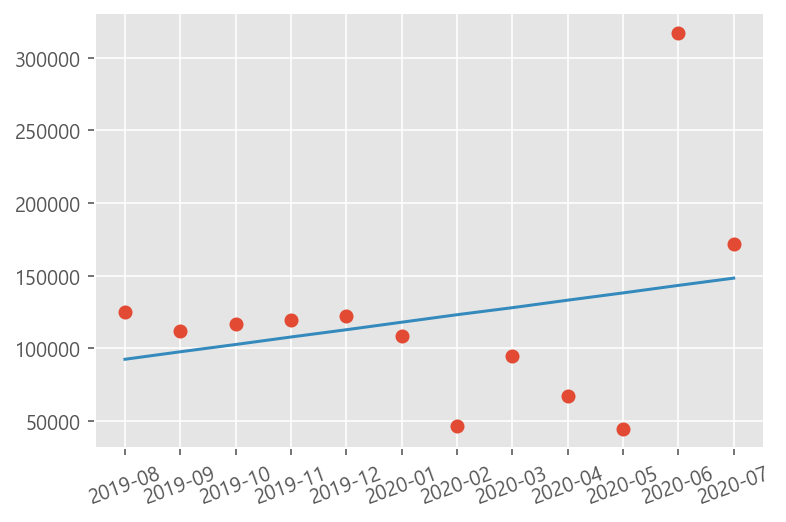

In [25]:
predict_people('중앙동','총 유동인구')

710130197원


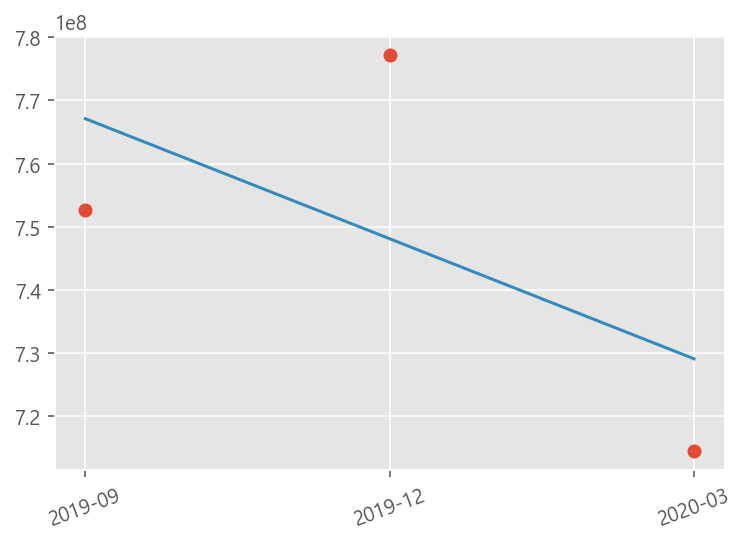

In [26]:
predict_money_power('금정구')

## 상권 분석 시각화

남포동


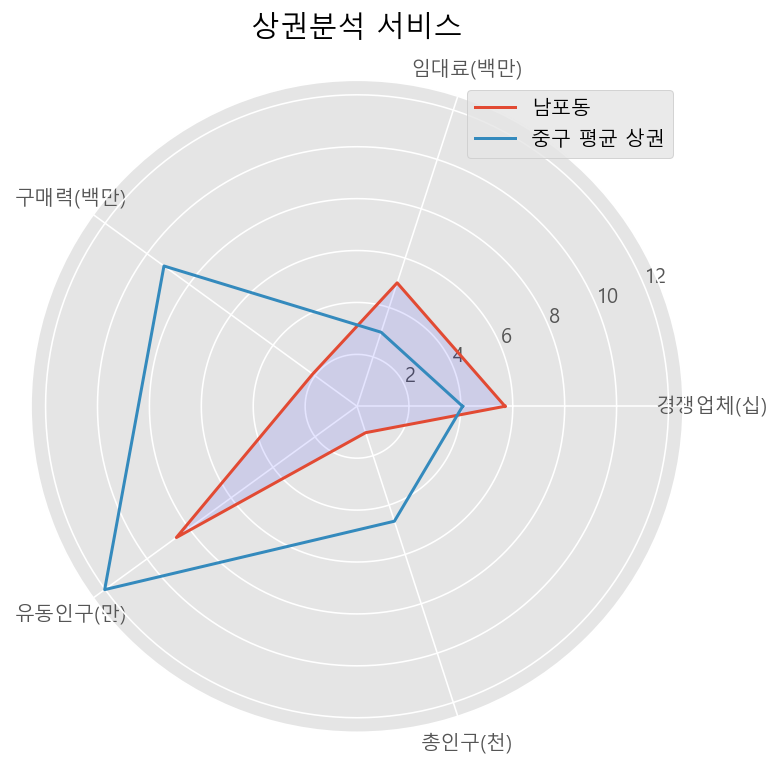

In [72]:
Depts = ["경쟁업체(십)","임대료(백만)","구매력(백만)","유동인구(만)", "총인구(천)"]

# 진입 상권
want_store=input()
want_data=data_per_dong[data_per_dong['읍면동']==want_store]
want_s=[want_data['경쟁업체 수'].tolist()[0]/10, 5000000/1000000, want_data['예측 구매력'].tolist()[0]/1000000, 
        want_data['예측 유동인구'].tolist()[0]/10000, want_data['총 인구'].tolist()[0]/1000, want_data['경쟁업체 수'].tolist()[0]/10]

# 평균 상권
ave_data=data_per_dong[data_per_dong['구군']==want_data['구군'].tolist()[0]]
ave_s=[ave_data['경쟁업체 수'].sum()/len(ave_data['경쟁업체 수'])/10,3000000/1000000, 
       want_data['구의 동별 평균 구매력'].tolist()[0]/1000000, ave_data['예측 유동인구'].sum()/len(ave_data['예측 유동인구'])/10000, 
       want_data['구의 동별 평균 인구'].tolist()[0]/1000,ave_data['경쟁업체 수'].sum()/len(ave_data['경쟁업체 수'])/10]

plt.figure(figsize=(10,6))
plt.subplot(polar=True)

theta = np.linspace(0, 2 * np.pi, len(want_s))

(lines,labels) = plt.thetagrids(range(0,360, int(360/len(Depts))), (Depts))

plt.plot(theta, want_s)
plt.fill(theta, want_s, 'b', alpha=0.1)
plt.plot(theta, ave_s)
plt.legend(labels=(want_store,want_data['구군'].tolist()[0]+' 평균 상권'),loc=1)
plt.title("상권분석 서비스")

plt.show();